| Name | Surname | ID Number |
|------|---------|---------------------|
| Lorenzo | Calandra Buonaura | 2107761 |

In [26]:
library("dplyr", warn.conflicts = FALSE)
library("ggplot2", warn.conflicts = FALSE)
library("geosphere", warn.conflicts = FALSE)
library("spatstat", warn.conflicts = FALSE)
library("gridExtra", warn.conflicts = FALSE)

# Exercise 1

A well established and diffused method for detecting a disease in blood fails to detect the presence of disease in 15% of the patients that actually have the disease. A young UniPD startUp has developed an innovative method of screening. During the qualification phase, a random sample of $n = 75$ patients known to have the disease is screened using the new method.

(a) what is the probability distribution of y, the number of times the new method fails to detect the disease?

For the previous method, the distribution is simply a binomial distribution with $p = 0.15$. Thus, if we consider for example $n = 75$, the posterior distribution of y (failures) can be plotted assuming a uniform prior.

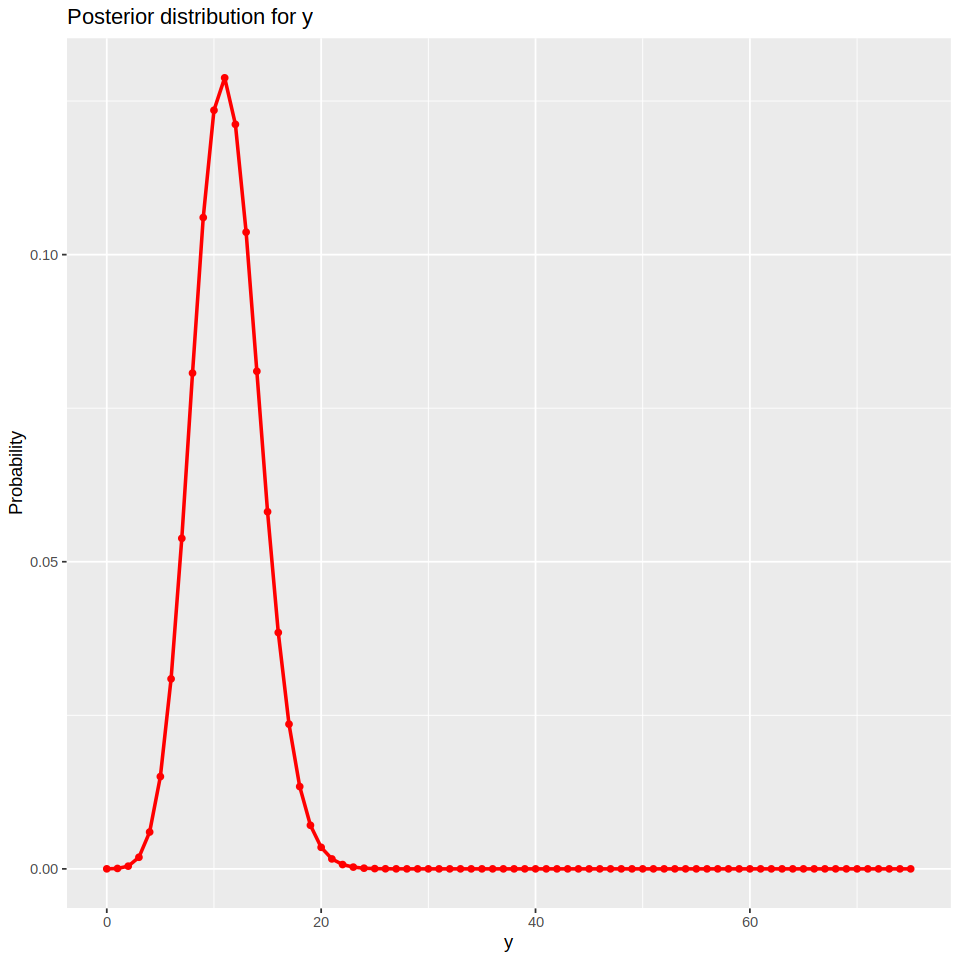

In [27]:
post_un <- function(r, n, limits, p) {
  uniform <- 1 / (limits[2] - limits[1])
  normalization <- sum(uniform * dbinom(r, n, p))

  return(uniform * dbinom(r, n, p) / normalization)
}

p <- 0.15

n <- 75
y <- seq(0, n, 1)

post_un_values <- post_un(y, n, c(min(y), max(y)), p)

options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(data = data.frame(y, post_un_values),
       aes(x = y, y = post_un_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  labs(title = "Posterior distribution for y",
       x = "y",
       y = "Probability")

For the new method we expect a similar distribution, where we don't actually know the probability of failure and which can be inferred from the data (as can be seen in the following questions).

(b) on the $n = 75$ patients sample, the new method fails to detect the disease in $y = 6$ cases. What is the frequentist estimator of the failure probability of the new method?

In [28]:
n <- 75
y <- 6

frequentist_estimator <- y / n

cat("Frequentist estimator of the failure probability:", frequentist_estimator)

Frequentist estimator of the failure probability: 0.08

(c) setup a bayesian computation of the posterior probability, assuming a beta distribution with mean value 0.15 and standard deviation 0.14. Plot the posterior distribution for y, and mark on the plot the mean value and variance.

For the beta distribution we have:

$
\begin{cases}
\mu = \frac{\alpha}{\alpha + \beta} \\
\sigma = \frac{\alpha\beta}{(\alpha + \beta)^2 (\alpha + \beta + 1)} 
\end{cases}
$

Inverting these formula we obtain: 

$
\begin{cases}
\alpha = \mu \left(\frac{\mu (1 - \mu)}{\sigma ^ 2} - 1\right) \\
\beta = \alpha \left( \frac{1}{\mu} - 1\right)
\end{cases}
$

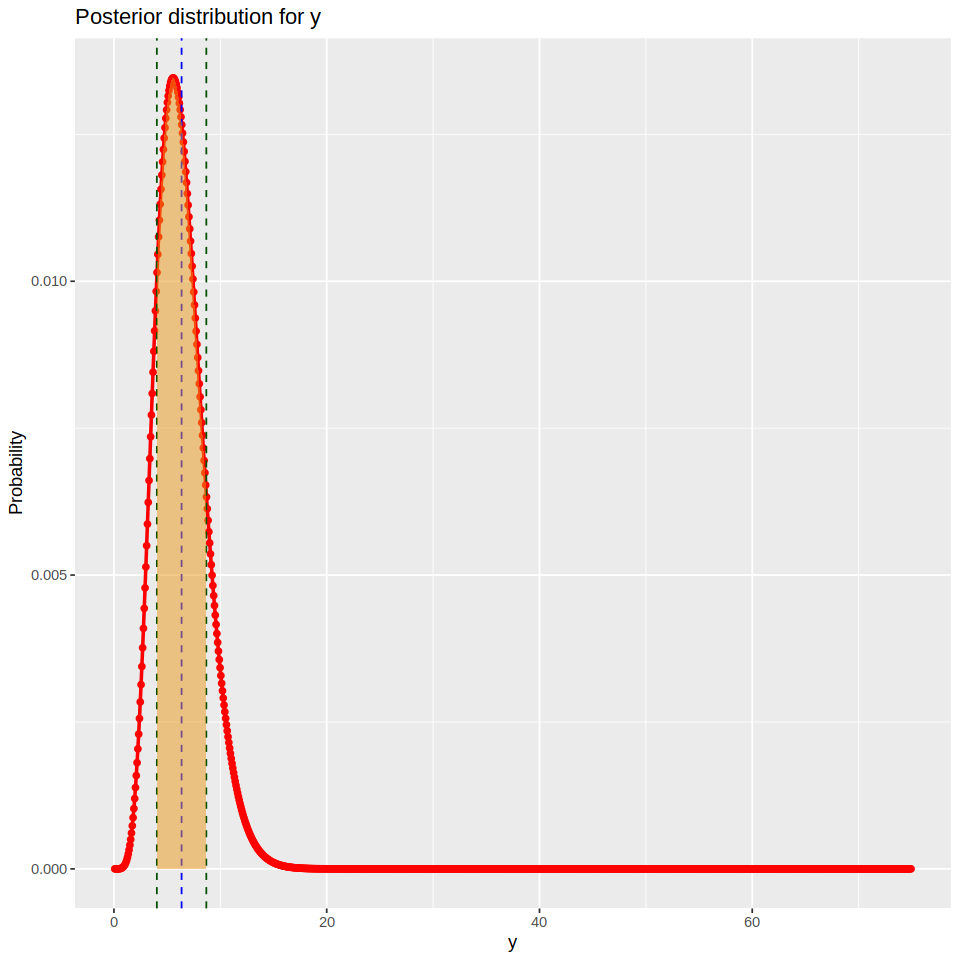

In [29]:
post_beta <- function(r, n, params, p) {
  beta <- dbeta(p, params[1], params[2])
  normalization <- sum(beta * dbinom(r, n, p))

  return(beta * dbinom(r, n, p) / normalization)
}

mu <- 0.15
sigma <- 0.14

alpha <- mu * (((mu * (1 - mu)) / sigma**2) - 1)
beta <- alpha * ((1 / mu) - 1)

p <- seq(0.001, 1 - 0.001, 0.001)

post_beta_values <- post_beta(y, n, c(alpha, beta), p)
mean_beta_value <- weighted.mean(p, post_beta_values) * n
std_beta_value <- sqrt(weighted.var(p, post_beta_values)) * n

std_limits <- c(round((mean_beta_value - std_beta_value) / n, digits = 3),
                round((mean_beta_value + std_beta_value) / n, digits = 3))

ggplot(data = data.frame(p * n, post_beta_values),
       aes(x = p * n, y = post_beta_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  geom_vline(xintercept = mean_beta_value,
             linetype = "dashed", color = "blue") +
  geom_vline(xintercept = mean_beta_value - std_beta_value,
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = mean_beta_value + std_beta_value,
             linetype = "dashed", color = "#035003") +
  geom_ribbon(data = subset(data.frame(p, post_beta_values), p >= std_limits[1] & p <= std_limits[2]),
              aes(ymin = 0, ymax = post_beta_values),
              fill = "#eb9719", alpha = 0.5) +
  labs(title = "Posterior distribution for y",
       x = "y",
       y = "Probability")

(d) Perform a test of hypothesis assuming that if the probability of failing to the detect the desease in ill patients is greater or equal than 15%, the new test is no better that the traditional method. Test the sample at a 5% level of significance in the Bayesian way.

In [30]:
prob_failure <- sum(post_beta_values[which(p >= 0.150)])

if (prob_failure < 0.05) {
  cat("The percentage of values with p >= 15% is", prob_failure * 100, "%, which is less than the 5% level of significance.", # nolinter
      "\nThus, we can reject the null hypothesis and state that the new test is better than the traditional method.\n") # nolinter
} else {
  cat("The percentage of values with p >= 15% is", prob_failure * 100, "%, which is more than the 5% level of significance.", # nolinter
      "\nThus, we cannot reject the null hypothesis and the new test is not better than the traditional method.\n") # nolinter
}

The percentage of values with p >= 15% is 3.210356 %, which is less than the 5% level of significance. 
Thus, we can reject the null hypothesis and state that the new test is better than the traditional method.


(e) Perform the same hypothesis test in the classical frequentist way.

In [31]:
p_null <- 0.15
p_value <- binom.test(y, n, p = p_null, alternative = "less")$p.value

if (p_value < 0.05) {
  cat("The p-value is", p_value * 100, "%, which is less than the 5% level of significance.", # nolinter
      "\nThus, we can reject the null hypothesis and state that the new test is better than the traditional method.\n") # nolinter
} else {
  cat("The p-value with p >= 15% is", p_value * 100, "%, which is more than the 5% level of significance.", # nolinter
      "\nThus, we cannot reject the null hypothesis and the new test is not better than the traditional method.\n") # nolinter
}


The p-value with p >= 15% is 5.43533 %, which is more than the 5% level of significance. 
Thus, we cannot reject the null hypothesis and the new test is not better than the traditional method.


# Exercise 2

A researcher has collected $n = 16$ observations that are supposed to come from a Normal distribution with known variance $\sigma ^ 2 = 4$

4.09 4.68 1.87 2.62 5.58 8.68 4.07 4.78 4.79 4.49 5.85 5.09 2.40 6.27 6.30 4.47

Assuming the prior is a step funtion:

$
g(\mu) = \begin{cases}
\mu & \quad \text{for} \quad 0 < \mu \leq 3 \\
3 & \quad \text{for} \quad 3 < \mu \leq 5 \\
8 −\mu & \quad \text{for} \quad 5 < \mu ≤8 \\
0 & \quad \text{for} \quad \mu > 8 
\end{cases}
$

(a) find the posterior distribution, the posterior mean and standard deviation.

In [32]:
data <- c(4.09, 4.68, 1.87, 2.62, 5.58, 8.68, 4.07, 4.78, 4.79,
          4.49, 5.85, 5.09, 2.40, 6.27, 6.30, 4.47)

n <- 16
var <- 4
mu <- seq(0, 10, 0.01)

prior <- function(mu) {
  n <- length(mu)
  results <- vector("list", n)

  for (i in 1:n) {
    if (0 < mu[i] && mu[i] <= 3) {
      results[i] <- mu[i]
    } else if (3 < mu[i] && mu[i] <= 5) {
      results[i] <- 3
    } else if (5 < mu[i] && mu[i] <= 8) {
      results[i] <- 8 - mu[i]
    } else {
      results[i] <- 0
    }
  }

  return(results)
}

post_norm <- function(data, mu, var, prior_values) {
  likelihood_values <- 1

  for (d in data){
    likelihood_values <- likelihood_values * dnorm(d, mu, sqrt(var))
  }

  normalization <- sum(prior_values * likelihood_values)
  return(prior_values * likelihood_values / normalization)
}

prior_values <- sapply(prior(mu), "[[", 1)
post_values <- post_norm(data, mu, var, prior_values)

mean_post <- weighted.mean(mu, post_values)
std_post <- sqrt(weighted.var(mu, post_values))

cat("Mean of the posterior distribution:", mean_post, "\n")
cat("Standard deviation of the posterior distribution:", std_post, "\n")

Mean of the posterior distribution: 4.725188 
Standard deviation of the posterior distribution: 0.4852065 


(b) find the 95% credibility interval for $\mu$.

In [33]:
c_int <- function(val, int, param) {
  low <- 0
  up <- 0
  a <- 1
  b <- 1

  limits <- c((1 - int) / 2, (1 + int) / 2)

  while (low < limits[1]) {
    low <- low + val[a]
    a <- a + 1
  }

  while (up < limits[2]) {
    up <- up + val[b]
    b <- b + 1
  }

  if (b > length(param)) {
    b <- length(param)
  }

  return(c(param[a], param[b]))
}

c_int_mu <- c_int(post_values, 0.95, mu)

cat("95% credibility interval for mu: (", c_int_mu[1], ",", c_int_mu[2], ")\n")

95% credibility interval for mu: ( 3.77 , 5.67 )


(c) plot the posterior distribution, indicating on the same plot: the mean value, the standard deviation, and the 95% credibility interval.

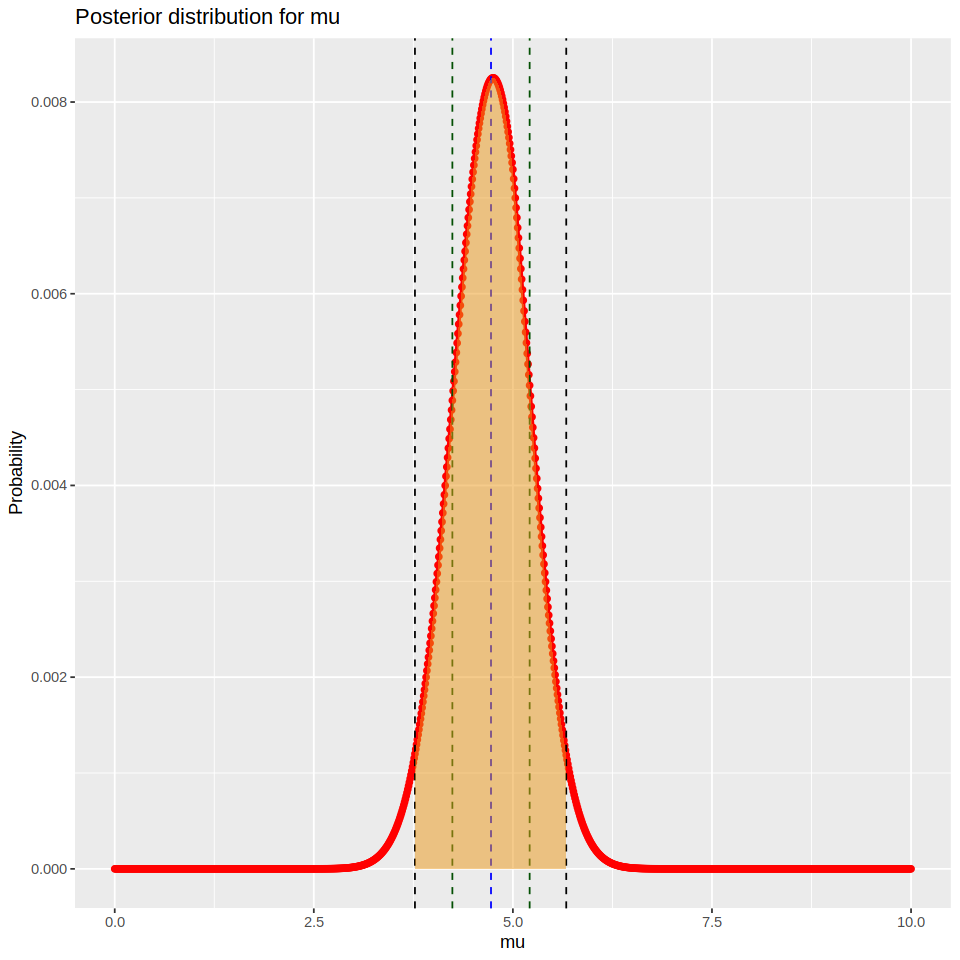

In [34]:
ggplot(data = data.frame(mu, post_values), aes(x = mu, y = post_values)) +
  geom_point(color = "red", size = 1.5) +
  geom_line(color = "red", linewidth = 1) +
  geom_vline(xintercept = mean_post,
             linetype = "dashed", color = "blue") +
  geom_vline(xintercept = mean_post - std_post,
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = mean_post + std_post,
             linetype = "dashed", color = "#035003") +
  geom_vline(xintercept = c_int_mu[1],
             linetype = "dashed", color = "#000000") +
  geom_vline(xintercept = c_int_mu[2],
             linetype = "dashed", color = "#000000") +
  geom_ribbon(data = subset(data.frame(mu, post_values),
                            mu >= c_int_mu[1] & mu <= c_int_mu[2]),
              aes(ymin = 0, ymax = post_values),
              fill = "#eb9719", alpha = 0.5) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability")

(d) plot, on the same graph, the prior, the likelihood and the posterior distribution.

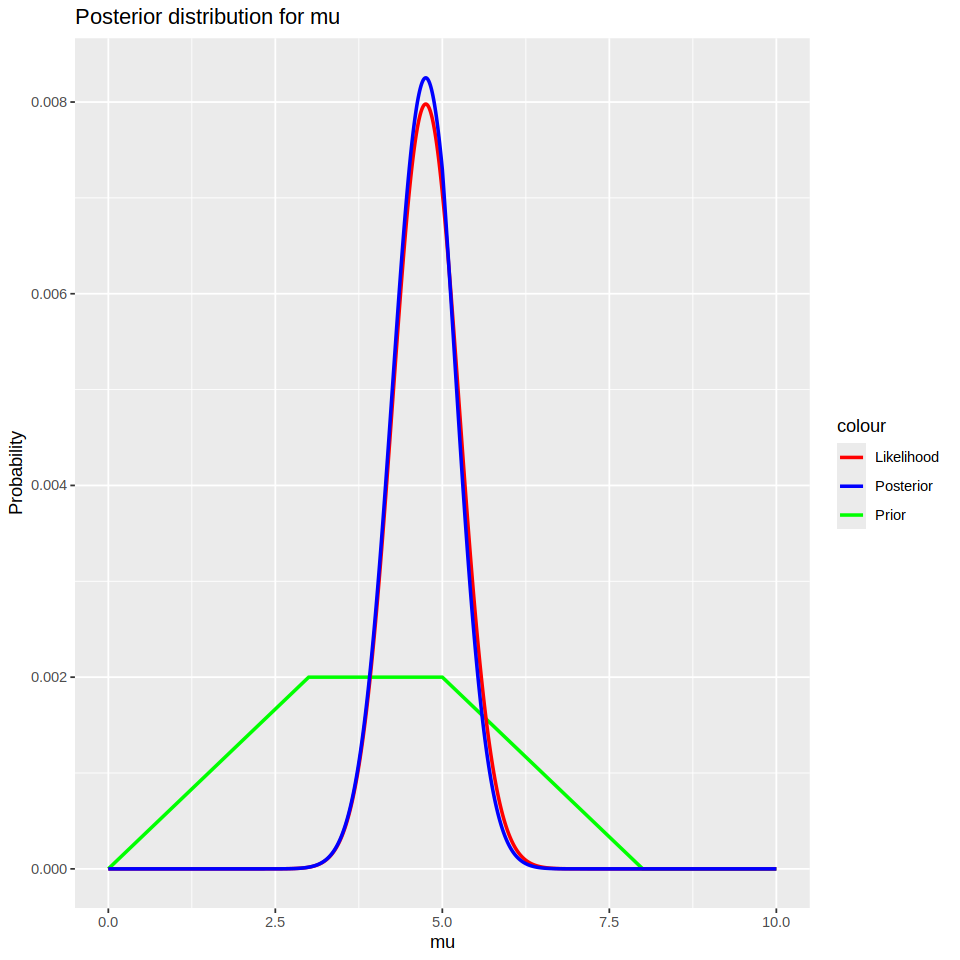

In [35]:
likelihood_values <- 1

for (d in data){
  likelihood_values <- likelihood_values * dnorm(d, mu, sqrt(var))
}

prior_values <- prior_values / sum(prior_values)
likelihood_values <- likelihood_values / sum(likelihood_values)

ggplot(data = data.frame(mu, prior_values, likelihood_values, post_values),
       aes(x = mu)) +
  geom_line(aes(y = prior_values, color = "Prior"), linewidth = 1) +
  geom_line(aes(y = likelihood_values, color = "Likelihood"), linewidth = 1) +
  geom_line(aes(y = post_values, color = "Posterior"), linewidth = 1) +
  labs(title = "Posterior distribution for mu",
       x = "mu",
       y = "Probability") +
  scale_color_manual(values = c("red", "blue", "green"),
                     labels = c("Likelihood", "Posterior", "Prior"))

# Exercise 3 - Six Boxes Toy Model : inference

Labeling the boxes as follows: $H_0$ (0 white stones), $H_1$ (1 white stones), $H_2$ (2 white stones), $H_3$ (3 white stones), $H_4$ (4 white stones), $H_5$ (5 white stones), write a program in R that:

1) selects a random box.
2) makes random sampling from the box.
3) prints on the standard output the probability of selecting each box.
4) plots the probability for each box as a function of the number of trials.